# <center> ***Proyecto Integrador*** </center>
## <center> ***Avance 3*** </center>
### Profesores: Dra. Grettel Barceló, Dr. Luis Enrique Falcón.
### Alumnos:

* Aurelio Antonio Lozano Rábago      A01081266


#### <p style='text-align: right;'> 19 de Mayo del 2024 </p>

As we have defined some options to move the rover, capture images, pre processing  them and train a  neural network using behavioral cloning techniquies aiming to autonomously record the boundary of an area to mow, next step is to develop the physical prototype of the rover and do the harware connections, settings and configuration to enable the actual prototype to capture the images, commands and use the artificial inteligence model.

The hardware to run the neural network will be a Nvida Orin Nano, which also will be capturing the images taken by a web camera connected via USB port. Orin will send the commands using Wi-Fi interface with Waveshare Rover ESP32 (for unknown reason the preferred serial interface is not working, due time constraints the debug of the issue was set on hold to allow progress on the weekly delivery).

To interface with Rover, the Oled display will be used, it will be the main interface to display the rover current state. 
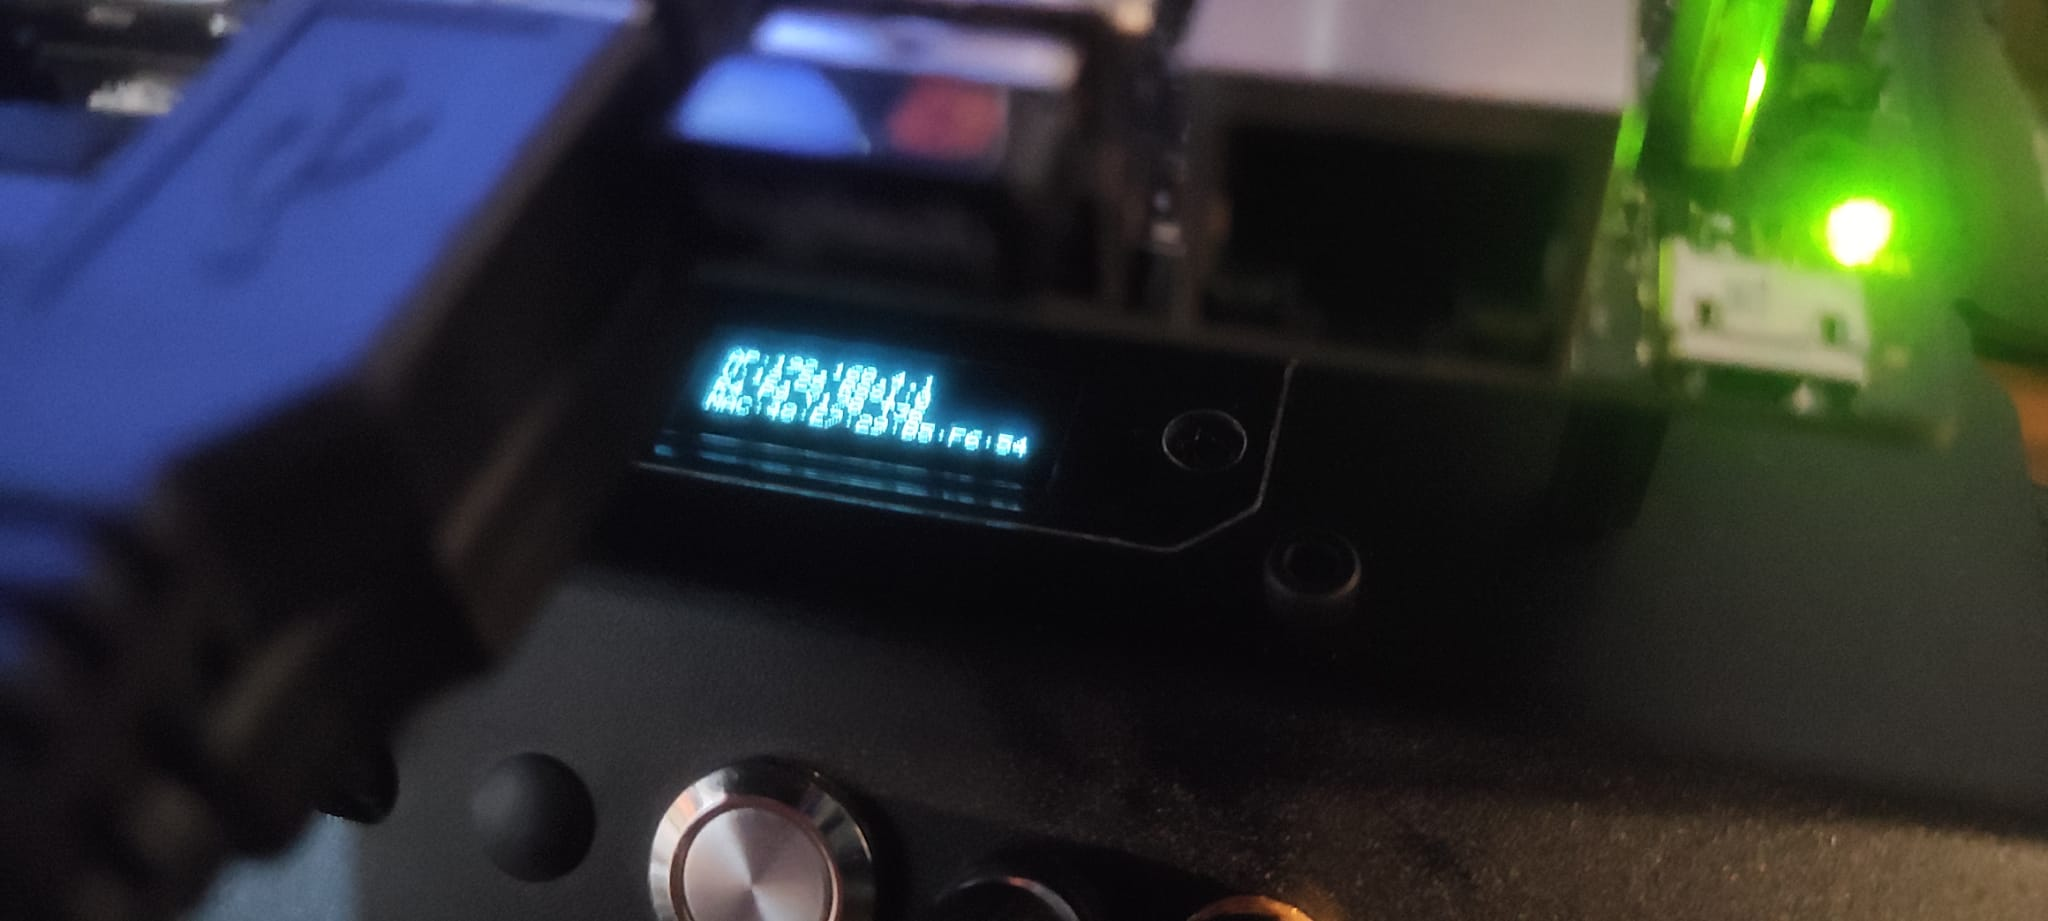

To power up the Nvidia Orin, the Rover batteries will be used, they provide ~12v and 9900ma. It was required to solder a 12 connector to the battery terminals at the Rover Board.
[<img src="Rover2.png">

Finally, the webcam will be placed around 27cm above the ground as it is a similar height of other autonomous mowers. Current prototype:

<img src="Rover1.png">

Software architecture is planned to have a finite state machine with 3 states: Idle, Recording (to capture images and commands) and Runnin (to execute autonomous operations)

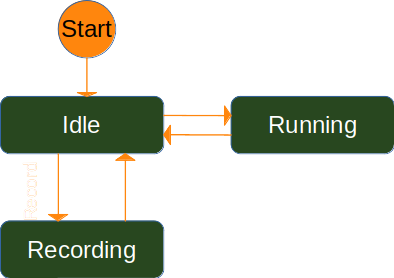

In [ ]:
'''
pip install keras
pip install matplotlib 
pip install opencv-python
pip install csv
pip install torch
pip install pandas
pip install scikit-learn
pip install Keyboard 
pip install requests
'''

In [14]:
import time
import matplotlib 
import cv2
import csv
import torch
import pandas
import keyboard
import requests
import json
from time import sleep
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


# Rover commands

In [15]:
def stop_command():
    command = "{'T':0}"
    command = json.dumps(command)
    return command

In [16]:
def write_display(line, text):
    command = {'T':3,'lineNum':line, 'Text':text}
    command = json.dumps(command)
    print(command)
    return command

In [17]:
# Configure retries for network-related errors
retry_strategy = Retry(
    total=1,  # Total number of retries
    backoff_factor=1,  # Wait 1 second before retrying
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these HTTP status codes
    allowed_methods=["GET", "POST"],  # Retry for these methods
)

adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)
http.mount("https://", adapter)


In [18]:
def send_json_command(command):

    ip = '192.168.4.1'
    password = '12345678'
    try:
        url = f"http://{ip}/js?json={command}"
        response = requests.get(url, auth=('admin', password))  # Using HTTP basic authentication
        content = response.text
        delay(1000)
    except RemoteDisconnected:
        pass


In [ ]:
def send_command(command):

    ip = '192.168.4.1'
    password = '12345678'
    try:
        url = f"http://{ip}/cmd?inputA=1&inputB=1&inputC=1"
        response = requests.get(url, auth=('admin', password))  # Using HTTP basic authentication
        content = response.text
        print(content)
    except RemoteDisconnected:
        pass

send_command()

In [10]:
def send_json_command(session, command, ip, password):
    try:
        url = f"http://{ip}/js?json={command}"
        response = session.get(url, auth=('admin', password))
        response.raise_for_status()  # Levanta una excepción para códigos de error HTTP
        content = response.text
        print(f"Response: {content}")
        sleep(1)  # Espera 1 segundo entre solicitudes
    except ConnectionError as e:
        print(f"Error de conexión: {e}")
    except HTTPError as e:
        print(f"Error HTTP: {e}")
    except Exception as e:
        print(f"Otro error: {e}")

def write_display(line, text):
    return f'{{"command": "write_display", "line": {line}, "text": "{text}"}}'



# Idle

Idle will include the state machine (work in progress)

In [1]:
class StateMachine:
    def _init_(self, initial_state):
        # Define the initial state
        self.state = initial_state
        # Welcome message
        with requests.Session() as session:
            send_json_command(session, write_display(0, "Welcome"), ip, password)   
        # Define the state transitions
        self.transitions = {}
    
    def add_transition(self, state, action, next_state):
        # Add a transition for a given state and action
        if state not in self.transitions:
            self.transitions[state] = {}
        self.transitions[state][action] = next_state

    def trigger(self, action):
        # Check if the action is valid for the current state
        if action in self.transitions.get(self.state, {}):
            self.state = self.transitions[self.state][action]
            print(f"Action '{action}' performed. New state: '{self.state}'")
        else:
            print(f"Action '{action}' is not valid in state '{self.state}'")

    def get_state(self):
        return self.state


In [24]:

send_json_command(write_display(0, "Welcome"))


In [23]:
send_json_command(write_display(1, "We are in Idle "))

In [ ]:
# Example usage
if _name_ == "_main_":
    # Create the state machine with an initial state
    fsm = StateMachine(initial_state='initial')

    # Define the states and transitions
    fsm.add_transition('initial', 'initialize', 'idle')
    fsm.add_transition('idle', 'start_running', 'running')
    fsm.add_transition('idle', 'start_recording', 'recording')
    fsm.add_transition('running', 'stop', 'idle')
    fsm.add_transition('recording', 'stop', 'idle')

    # Demonstrate state transitions
    print(f"Initial state: {fsm.get_state()}")
    fsm.trigger('initialize')
    fsm.trigger('start_running')
    fsm.trigger('stop')
    fsm.trigger('start_recording')
    fsm.trigger('stop')

    # Invalid action example
    fsm.trigger('start_recording')
    fsm.trigger('initialize')

# Recording

This state will take care to capture the images and commands that will be used to train the Neural Network

In [25]:
#Library import
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scapy.all import *
from scapy.all import AsyncSniffer
from scapy.layers.http import HTTP
from scapy.layers.http import HTTPRequest
import torch


import csv
import os

In [ ]:
print(torch.__version__)
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [26]:
#Filtering non green areas
# Define the green color range
lower_green = np.array([20, 30, 40])  # low green value
upper_green = np.array([90, 255, 255]) # high green value

#Blur + Canny + Hough
alpha=1
beta=1
gamma=1

# Abrir el archivo CSV para escribir
csv_file = open('paths.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)

In [ ]:
# Define a function to handle captured packets
def handle_packet(packet):
    if packet.haslayer('HTTP') and packet['HTTP'].haslayer('HTTPRequest'):
        method = packet['HTTP']['HTTPRequest'].Method.decode()
        path = packet['HTTP']['HTTPRequest'].Path.decode()
        if method == 'GET' and path.startswith("/cmd"):
            path_row = [path]
            image_name = f"image_{len(os.listdir('images'))}.jpg"
            image_path = os.path.join("images", image_name)
            path_row.append(image_path)

            ret, frame = cap.read()
            if ret:
                hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
                mask = cv2.inRange(hsv, lower_green, upper_green)
                blurred_image = cv2.bitwise_and(frame, frame, mask=mask)
                filtered_image = cv2.blur(blurred_image, (5, 5))
                canny_filtered_image = cv2.Canny(filtered_image, 100, 200)
                lines = cv2.HoughLinesP(canny_filtered_image, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=10)
                img_lines = np.copy(frame)
                if lines is not None:
                    for line in lines:
                        x1, y1, x2, y2 = line[0]
                        cv2.line(img_lines, (x1, y1), (x2, y2), [0, 0, 255], 7)
                img_lane_lines = cv2.addWeighted(frame, alpha, img_lines, beta, gamma)
                img_lane_lines = cv2.cvtColor(img_lane_lines, cv2.COLOR_BGR2RGB)
                cv2.imwrite(image_path, img_lane_lines)
                csv_writer.writerow(path_row)

# Start capturing packets in real-time
sniff_thread = AsyncSniffer(prn=handle_packet, filter="host 192.168.4.1 and port 80")
sniff_thread.start()

# Start capturing video from the camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open the camera")
    exit()

# Get the current camera resolution
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Reduce the resolution to one-fourth
new_width = width // 2
new_height = height // 2

# Set the new camera resolution
cap.set(cv2.CAP_PROP_FRAME_WIDTH, new_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, new_height)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Cannot receive frame. Exiting...")
        break
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

# Stop capturing packets in real-time
sniff_thread.stop()

# Release the camera capture
cap.release()

# Close the CSV file
csv_file.close()

# Close OpenCV windows
cv2.destroyAllWindows()

# Running

In [29]:
def preprocess_image(image):    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    blurred_image = cv2.bitwise_and(frame, frame, mask=mask)
    filtered_image = cv2.blur(blurred_image, (5, 5))
    canny_filtered_image = cv2.Canny(filtered_image, 100, 200)
    lines = cv2.HoughLinesP(canny_filtered_image, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=10)
    img_lines = np.copy(frame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_lines, (x1, y1), (x2, y2), [0, 0, 255], 7)
    img_lane_lines = cv2.addWeighted(frame, alpha, img_lines, beta, gamma)
    img_lane_lines = cv2.cvtColor(img_lane_lines, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# load model
model = load_model('model1.h5')


    # reshape as expected by Nvidia model (66, 200, 3) 
    image = cv2.resize(image, (200, 66))
    # Normalize
    image = image / 255.0


# Inicializar la cámara
cap = cv2.VideoCapture(0)  # O default camera index

while True:
    # capture frame
    ret, frame = cap.read()
    if not ret:
        break

    # pre process image
    preprocessed_frame = preprocess_image(frame)

    # resize to match expected size (1, 66, 200, 3)
    preprocessed_frame = np.expand_dims(preprocessed_frame, axis=0)

    # Do the prediction
    steering_angle = model.predict(preprocessed_frame)[0]

    #send predicted command to rover rover
    send_command(command)

    # Press 'q' para salir
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar todas las ventanas
cap.release()
cv2.destroyAllWindows()

## Data gathering

Once the rover has captured the images and commands, they can be dumped to train the model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_images_and_commands(csv_path, img_dir):
    # Cargar el archivo CSV
    data = pd.read_csv(csv_path, names=['Path', 'Image_Path'])

    # Leer las rutas de las imágenes y los comandos
    image_paths = data['Image_Path'].values
    commands = data['Path'].values

    # Dividir los datos en conjuntos de entrenamiento y validación
    train_image_paths, val_image_paths, train_commands, val_commands = train_test_split(image_paths, commands, test_size=0.2, random_state=42)

    return train_image_paths, val_image_paths, train_commands, val_commands

# Ruta al archivo CSV generado
csv_path = 'paths.csv'
# Directorio donde se guardaron las imágenes
img_dir = 'images'

# Cargar imágenes y comandos y generar conjuntos de entrenamiento y validación
train_image_paths, val_image_paths, train_commands, val_commands = load_images_and_commands(csv_path, img_dir)

# Imprimir la cantidad de datos de entrenamiento y validación
print(f"Datos de entrenamiento: {len(train_image_paths)}")
print(f"Datos de validación: {len(val_image_paths)}")

# training

In [ ]:

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
def nvidia_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Convolution2D(3, (5, 5), strides=(1, 1), input_shape=(66, 200, 3), activation='relu'))
    model.add(tf.keras.layers.Convolution2D(3, (5, 5), strides=(1, 1), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Convolution2D(24, (5, 5), strides=(1, 1), activation='relu'))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Convolution2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Convolution2D(48, (3, 3), strides=(2, 2), activation='relu'))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), strides=(2, 2), activation='relu'))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1164, activation='relu'))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
model=nvidia_model()

In [ ]:
history = model.fit(
    batch_generator(X_train, y_train, 500, 1),
    steps_per_epoch=30,
    epochs=80,
    validation_data=batch_generator(X_valid, y_valid, 500, 0),
    validation_steps=30,
    #class_weight=class_weights, 
    verbose=1,
    shuffle=True

)

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

model.save('model1.h5')

NameError: name 'history' is not defined